In [96]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy

folder = '../data'
merge_file = 'prepilot'
plot_folder = '../plots/prepilot'

experiments = [
    {
        'pagetimes': 'PageTimes-2021-12-09.csv',
        'main_part': 'main_part_pilot_2021-12-09.csv',
        'folder': '../data/prepilot'
    },
    {
        'pagetimes': 'PageTimes-2021-12-13.csv',
        'main_part': 'main_part_pilot_2021-12-13.csv',
        'folder': '../data/prepilot2'
    }, 
    {
        'pagetimes': 'PageTimes-2021-12-20.csv',
        'main_part': 'main_part_pilot_cont_2021-12-20.csv',
        'folder': '../data/prepilot4'
    }, 
    {
        'pagetimes': 'PageTimes-2022-01-13.csv',
        'main_part': 'main_part_pilot_cont_2022-01-13.csv',
        'folder': '../data/prepilot5'
    }, 
]


session_map = {
    'sdvfxj22': 'flextimes', 
    'n8op39bm': 'fixedtimes',
    'qeklctjv': 'continous_exp',
    'a4ly7fp4': 'continous_cheap',
    'yi3xaim0': 'trail_rounds'
}



exp_pool = {
    'flextimes': 'discrete', 
    'fixedtimes': 'discrete',
    'continous_exp': 'continous',
    'continous_cheap': 'continous',
    'trail_rounds': 'trail_rounds'
}



dfs = []
dfts = []
for exp in experiments:
    df = pd.read_csv(os.path.join(exp['folder'], exp['main_part']))
    dft = pd.read_csv(os.path.join(exp['folder'], exp['pagetimes']))
    df['experiment_name'] = df['session.code'].map(session_map)
    dft['experiment_name'] = dft['session_code'].map(session_map)
    df['experiment_pool'] = df['experiment_name'].map(exp_pool)
    dfs.append(df)
    dfts.append(dft)
df = pd.concat(dfs)
dft = pd.concat(dfts)
df['experiment_name'].value_counts()

flextimes          1440
fixedtimes         1440
continous_exp      1440
continous_cheap    1440
trail_rounds        960
Name: experiment_name, dtype: int64

In [97]:

max_player = 4

# where = (
#     (df['player.id_in_group'] >= 2) & 
#     (df['player.id_in_group'] <= max_player + 1)
# )

where = (
    (df['player.role'] != 'manager') &
    (~df['player.role'].isnull()) &
    (df['participant._current_page_name'] == 'FinalScreen')
)

df = df[where]


def get_punishment(row):
    member_idx = row['player.role'][-1]
    return row[f"group.punishment{member_idx}"]

rename = {
    'session.code': 'session', 
    'group.id_in_subsession': 'group_id', 
    'subsession.round_number': 'round_number',
    'participant.code': 'participant_code',
    'player.contribution': 'contribution',
    'player.no_input': 'player_no_input',
    'player.contribution': 'contribution',
    'player.punishment': 'punishment',
    'group.no_input_manager': 'manager_no_input',
    'group.total_contribution': 'total_contribution',
    'group.common_good': 'common_good',
    'group.total_punishment': 'total_punishment',
    'episode': 'episode',
    'experiment_name': 'experiment_name',
    'player.role': 'player_role',
    'player.payoff': 'payoff',
    'experiment_pool': 'experiment_pool'
}

df['episode'] = (df['subsession.round_number'] - 1) // 8 + 1


df['player.punishment'] = df.apply(get_punishment, axis=1)

df = df[rename.keys()]
df = df.rename(columns=rename)

df['round_number'] = df['round_number'] % 8 
# dft = dft[dft['page_name'] == 'Results']
# merge_on = ['experiment_name', 'round_number', 'participant_code']

df['global_group_id'] = df['experiment_name'] + ' #' + df['group_id'].astype('str')

# df = df.merge(dft[merge_on + ['epoch_time_completed']], on=merge_on, how='left')


# df['group_started'] = df.groupby(['group_id', 'session'])['epoch_time_completed'].transform('min')
# df['global_group_id'] = df['group_started'].rank(method='dense').astype(int)

# df['time_passed'] = df['epoch_time_completed'] - df.groupby('participant_code')['epoch_time_completed'].transform('min')
# df['group_duration'] = df.groupby('global_group_id')['time_passed'].transform('max')
# df['group_duration_min'] = df['group_duration'] / 60



In [98]:
groupby = ['global_group_id', 'round_number']

# check total_contribution
# check = df.groupby(groupby)['total_contribution'].transform('first') == df.groupby(groupby)['contribution'].transform('sum')
# assert check.all(), 'Sum of total contributions does not match group contribution.'
# check = df.groupby(groupby)['total_contribution'].count()
# assert check.nunique() == 1, 'There are different number of data points per round'
# check = df.groupby(groupby[:-1])['total_contribution'].count()
# assert check.nunique() == 1, 'There are different number of data points per group'


In [99]:
df.to_csv(os.path.join(folder, f'{merge_file}_player_round.csv'))

<Figure size 1008x720 with 0 Axes>

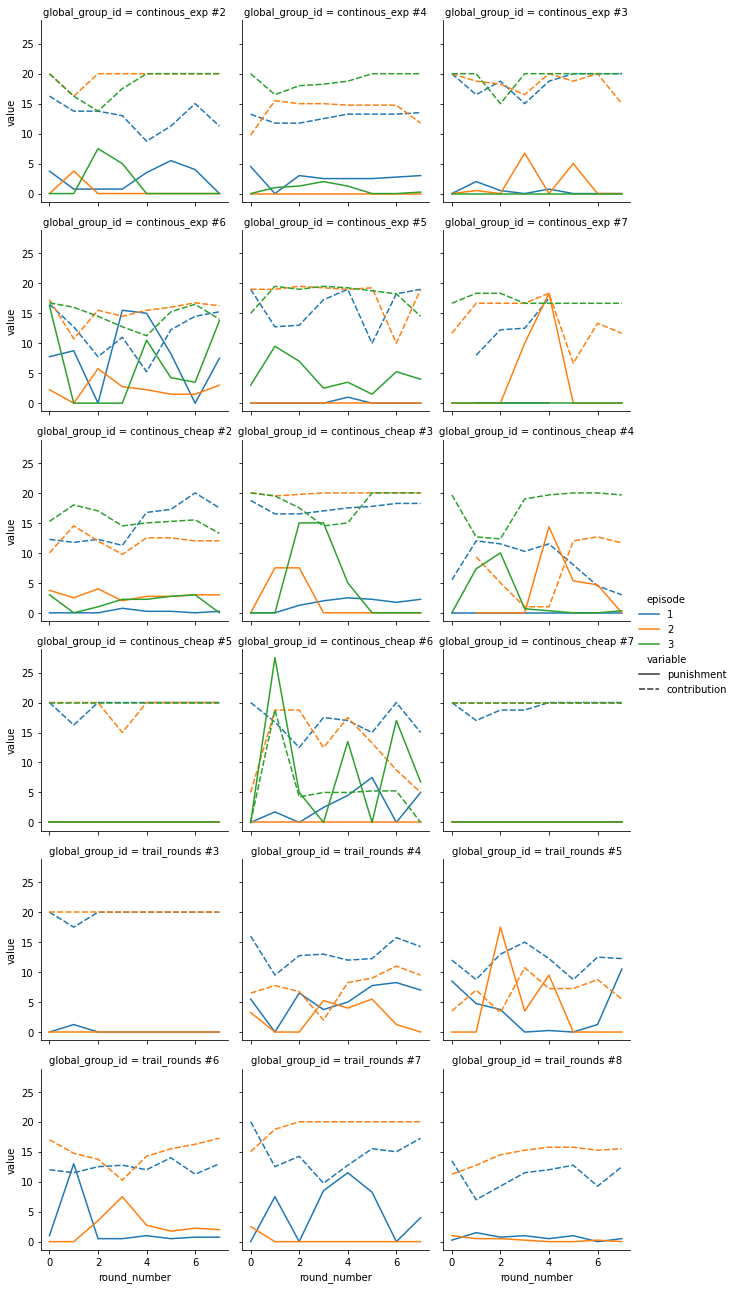

In [100]:
plt.figure(figsize=(14,10))

dfm = df.melt(
    id_vars=['global_group_id', 'round_number', 'participant_code', 'episode', 'experiment_name', 'experiment_pool'], 
    value_vars=['punishment', 'contribution'])

dfm['episode'] = dfm['episode'].astype(str)

where = (dfm['experiment_name'].isin(['continous_cheap', 'continous_exp', 'trail_rounds']))

g = sns.relplot(
    data=dfm[where],
    x="round_number", y="value", col='global_group_id', hue='episode',
    style='variable',
    kind="line", ci=None,
    col_wrap=3, height=3, aspect=1,

)
plt.savefig(os.path.join(plot_folder, 'temporal.jpg'), dpi=300, transparent=False)

/home/local/MPIB-BERLIN/brinkmann/repros/algorithmic-institutions/.venv/lib/python3.9/site-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


<Figure size 864x360 with 0 Axes>

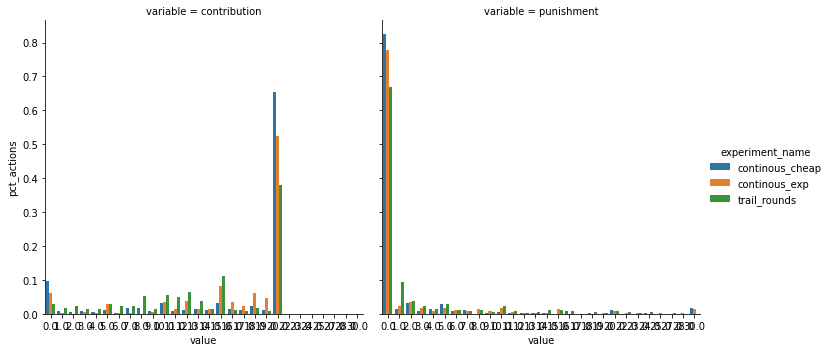

In [101]:
plt.figure(figsize=(12,5))


dfg = dfm.groupby(['experiment_name', 'variable', 'value'])['participant_code'].count()
dfg = dfg / dfg.groupby(['experiment_name','variable']).transform('sum')
dfg = dfg.reset_index()

dfg = dfg.rename(columns={'participant_code': 'pct_actions'})


dfg = dfg[dfg['experiment_name'].isin(['continous_cheap', 'continous_exp', 'trail_rounds'])]

sns.factorplot(x="value", y='pct_actions', col='variable', hue="experiment_name", data=dfg, kind='bar')
# plt.legend(bbox_to_anchor=(0.7, 0.95), loc=2, borderaxespad=0.)
plt.savefig(os.path.join(plot_folder, 'contribution_punishments.jpg'), dpi=300, transparent=False)

/home/local/MPIB-BERLIN/brinkmann/repros/algorithmic-institutions/.venv/lib/python3.9/site-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


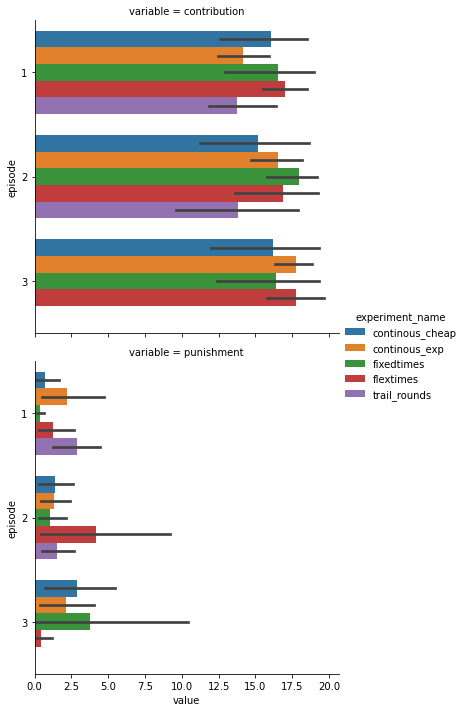

In [102]:
dfg = dfm.groupby(["experiment_pool", 'experiment_name', 'global_group_id', 'episode', 'variable'])['value'].mean()
dfg = dfg.reset_index()

sns.factorplot(x="value", y='episode', hue="experiment_name", row='variable', data=dfg, orient='h', kind='bar')
plt.savefig(os.path.join(plot_folder, 'contribution_punishments_pooled_bar.jpg'), dpi=300, transparent=False)

In [116]:
import statsmodels.formula.api as smf
data = df
results = smf.glm("contribution ~ C(experiment_name, Treatment(reference='continous_exp')) + C(episode, Treatment(reference=1)) + C(round_number, Treatment(reference=1))  ", data=data).fit()
print(results.summary().tables[1])

                                                                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                      15.3782      0.431     35.708      0.000      14.534      16.222
C(experiment_name, Treatment(reference='continous_exp'))[T.continous_cheap]    -0.3065      0.359     -0.853      0.394      -1.011       0.398
C(experiment_name, Treatment(reference='continous_exp'))[T.fixedtimes]          0.9637      0.359      2.686      0.007       0.261       1.667
C(experiment_name, Treatment(reference='continous_exp'))[T.flextimes]           0.9685      0.356      2.718      0.007       0.270       1.667
C(experiment_name, Treatment(reference='continous_exp'))[T.trail_rounds]       -2.2922      0.407     -5.627      0.000      -3.091     

<Figure size 1008x720 with 0 Axes>

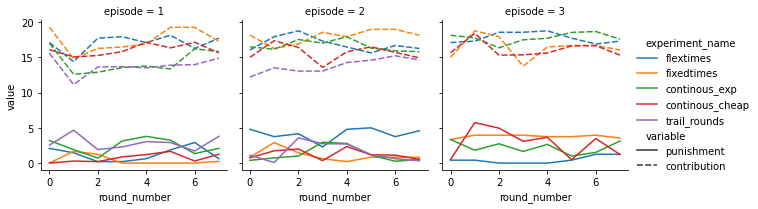

In [118]:
plt.figure(figsize=(14,10))

dfm = df.melt(
    id_vars=['global_group_id', 'round_number', 'participant_code', 'episode', 'experiment_name', 'experiment_pool'], 
    value_vars=['punishment', 'contribution'])

dfm['episode'] = dfm['episode'].astype(str)

# where = (dfm['experiment_name'].isin(['continous_cheap', 'continous_exp', 'trail_rounds']))

g = sns.relplot(
    data=dfm,
    x="round_number", y="value", hue='experiment_name',
    col='episode',
    style='variable',
    kind="line", ci=None,
    height=3, aspect=1,
)
plt.savefig(os.path.join(plot_folder, 'temporal.jpg'), dpi=300, transparent=False)

In [105]:
dfg

,experiment_pool,experiment_name,global_group_id,episode,variable,value
0,continous,continous_cheap,continous_cheap #2,1,contribution,14.87500
1,continous,continous_cheap,continous_cheap #2,1,punishment,0.18750
2,continous,continous_cheap,continous_cheap #2,2,contribution,11.90625
3,continous,continous_cheap,continous_cheap #2,2,punishment,2.96875
4,continous,continous_cheap,continous_cheap #2,3,contribution,15.46875
...,...,...,...,...,...,...
163,trail_rounds,trail_rounds,trail_rounds #7,2,punishment,0.31250
164,trail_rounds,trail_rounds,trail_rounds #8,1,contribution,10.96875
165,trail_rounds,trail_rounds,trail_rounds #8,1,punishment,0.68750
166,trail_rounds,trail_rounds,trail_rounds #8,2,contribution,14.50000


/home/local/MPIB-BERLIN/brinkmann/repros/algorithmic-institutions/.venv/lib/python3.9/site-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/home/local/MPIB-BERLIN/brinkmann/repros/algorithmic-institutions/.venv/lib/python3.9/site-packages/seaborn/categorical.py:3723: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


<Figure size 1440x360 with 0 Axes>

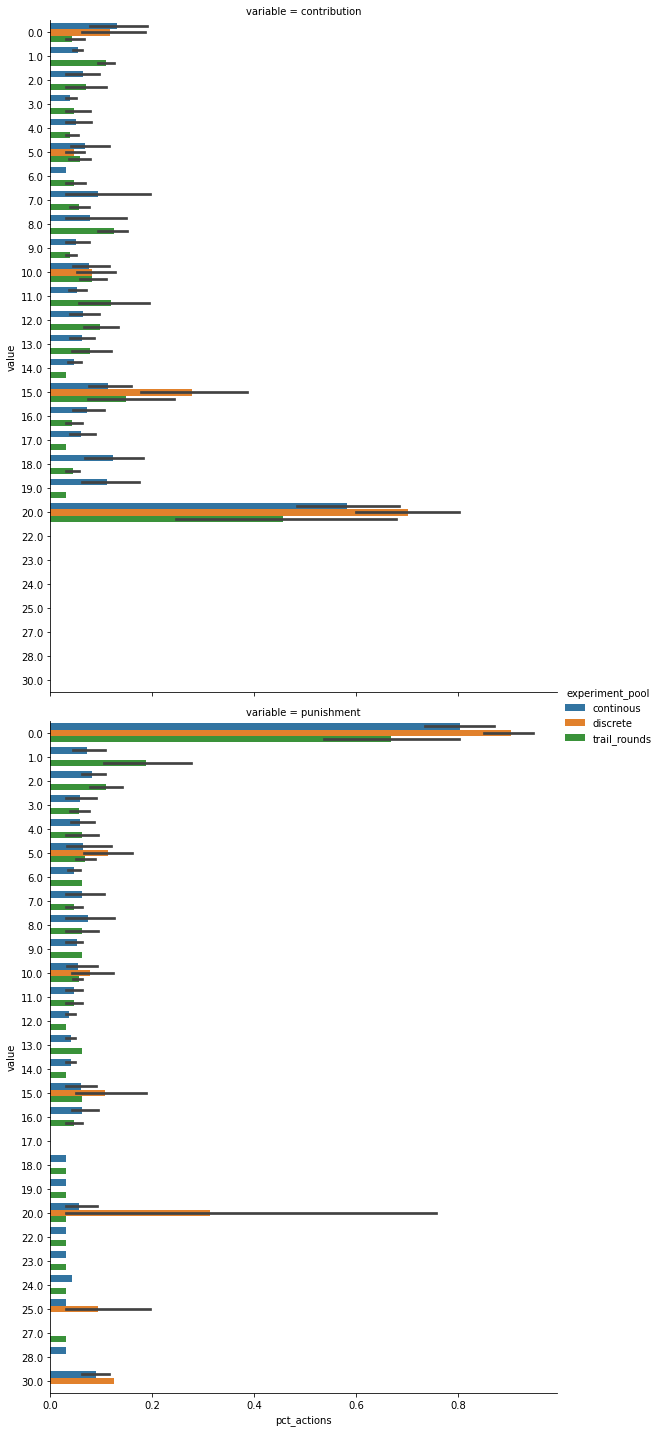

In [106]:
plt.figure(figsize=(20,5))


dfg = dfm.groupby(['experiment_pool', 'global_group_id', 'episode', 'variable', 'value'])['participant_code'].count()
dfg = dfg / dfg.groupby(['experiment_pool', 'global_group_id', 'episode', 'variable']).transform('sum')
dfg = dfg.reset_index()

dfg = dfg.rename(columns={'participant_code': 'pct_actions'})

sns.factorplot(y="value", x='pct_actions', row='variable', hue="experiment_pool", data=dfg, kind='bar', orient='h', size=10, aspect=0.8)
# plt.legend(bbox_to_anchor=(0.7, 0.95), loc=2, borderaxespad=0.)
# plt.title('Pooled over continous cheap + continous expensive')
plt.savefig(os.path.join(plot_folder, 'contribution_punishments_pooled.jpg'), dpi=300, transparent=False)

<Figure size 576x360 with 0 Axes>

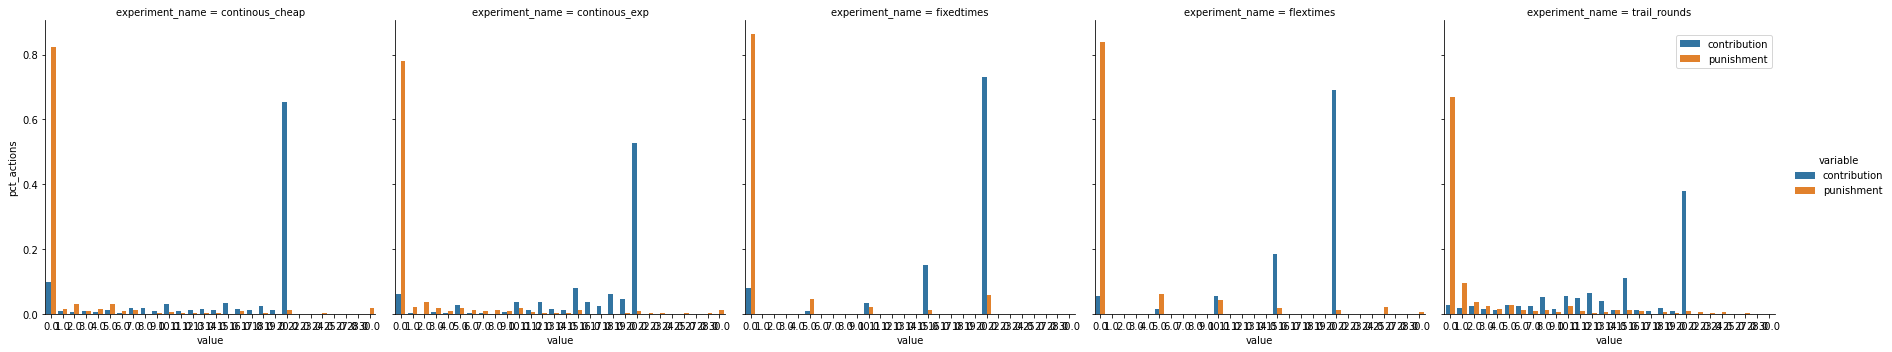

In [107]:
plt.figure(figsize=(8,5))


dfg = dfm.groupby(['experiment_name', 'variable', 'value'])['participant_code'].count()
dfg = dfg / dfg.groupby(['experiment_name','variable']).transform('sum')
dfg = dfg.reset_index()

dfg = dfg.rename(columns={'participant_code': 'pct_actions'})


sns.catplot(x="value", y='pct_actions', hue="variable", col='experiment_name', data=dfg, kind="bar",)
plt.legend(bbox_to_anchor=(0.7, 0.95), loc=2, borderaxespad=0.)
plt.savefig(os.path.join(plot_folder, 'contribution_punishments.jpg'), dpi=300, transparent=False)

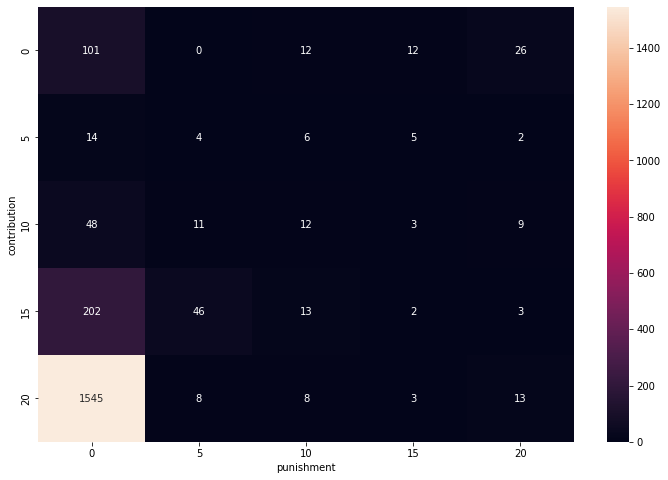

In [108]:
plt.figure(figsize=(12,8))
pt = df.pivot_table(index='contribution', columns='punishment', values='participant_code', aggfunc='count')
pt = pt.reindex(columns=range(0,25,5), index=range(0,25,5)).fillna(0).astype(int)
sns.heatmap(pt, annot=True, fmt='d')
plt.savefig(os.path.join(plot_folder, 'contribution_punishments_matrix.jpg'), dpi=300, transparent=False)

In [ ]:
w = df['manager_no_input'] == 0

dfe = df[w].groupby(['global_group_id', 'player_role','experiment_name'])[['punishment', 'contribution']].mean().reset_index()

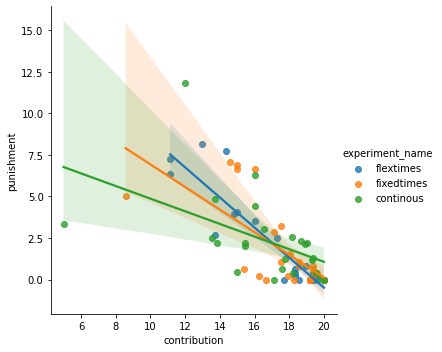

In [ ]:
# sns.regplot(data=dfe, x='punishment', y='contribution')
sns.lmplot(data=dfe, y='punishment', x='contribution', hue='experiment_name')

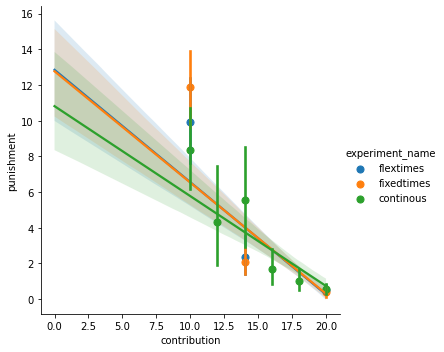

In [ ]:
# sns.regplot(data=dfe, x='punishment', y='contribution')
sns.lmplot(data=df[w], y='punishment', x='contribution', hue='experiment_name', x_bins=list(range(10,21,2)))

In [ ]:
df['efficiency'] = df['contribution'] - df['punishment']
df.groupby('experiment_name')['efficiency'].mean()

experiment_name
continous     14.275926
fixedtimes    15.494604
flextimes     15.269097
Name: efficiency, dtype: float64

In [ ]:
df[['prev_punishment', 'prev_contribution', 'prev_manager_no_input']] = df[w].groupby(['global_group_id', 'player_role','experiment_name'])[['punishment', 'contribution', 'manager_no_input']].shift(-1)
df[['prev2_punishment', 'prev2_contribution']] = df[w].groupby(['global_group_id', 'player_role','experiment_name'])[['punishment', 'contribution']].shift(-2)

In [ ]:
df['delta_prev_punishment'] = df['prev_punishment'] - df['prev2_punishment']
df['delta_contribution'] = df['contribution'] - df['prev_contribution']

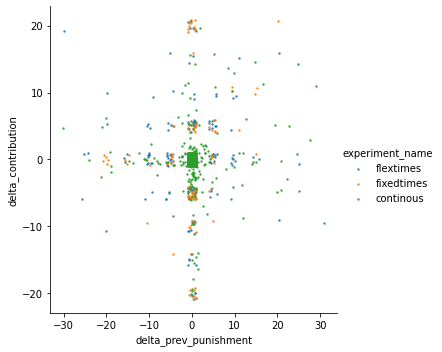

In [ ]:
w = (
    (df['manager_no_input'] == 0) &
    (~df['delta_prev_punishment'].isnull()) &
    (~df['delta_contribution'].isnull())
)
# , x_bins=range(-20,21,5)
g = sns.lmplot(data=df[w], y='delta_contribution', x='delta_prev_punishment', hue='experiment_name', scatter_kws={"s": 2}, x_jitter=1, y_jitter=1, fit_reg=False)
# g.set(xlim=[0,30])




In [ ]:
for idx, dfgg in df[w].groupby('experiment_name'):
    r, p = scipy.stats.pearsonr(dfgg['delta_prev_punishment'], dfgg['delta_contribution'])
    print(f'{idx} has a correlation of {r} (p = {p}) between delta of contributions and previous delta of punishments')


continous has a correlation of 0.08991433413164279 (p = 0.07173248652029983) between delta of contributions and previous delta of punishments
fixedtimes has a correlation of 0.15185278715597664 (p = 0.0008035204331305389) between delta of contributions and previous delta of punishments
flextimes has a correlation of -0.044876276321102436 (p = 0.307070410107947) between delta of contributions and previous delta of punishments


Text(0.5, 1.0, 'Filtered on (prev_contribution <= 15) and (prev_manager_no_input == 0)')

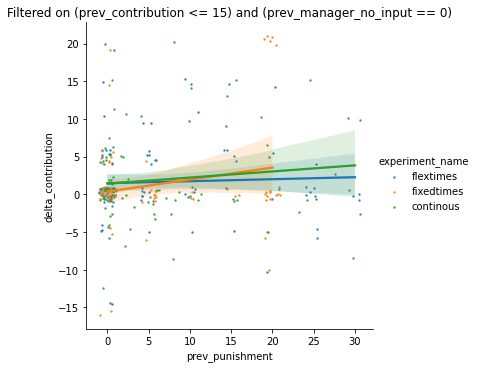

In [ ]:
w = (
    (df['prev_contribution'] <= 15) &
    (df['prev_manager_no_input'] == 0)
)
g = sns.lmplot(data=df[w], y='delta_contribution', x='prev_punishment', hue='experiment_name', scatter_kws={"s": 2}, x_jitter=1, y_jitter=1, fit_reg=True)
plt.title('Filtered on (prev_contribution <= 15) and (prev_manager_no_input == 0)')
